# M1SD TP03 $\pi$ Monte Carlo

Jit (@decorator def f(x): pega uma funcao f' que é igual ao decorator (cria um novo codigo))
- 1e passe: generait du code machine
- 2e passe: utilisait code machine

ProcessPoolExecutor
- p_exe.map(f, data): envia os dados separadamente para diferentes processos (o primeiro chunk ativa o 1e passe)
- t_exe.map(): Os threads compartilham memoria, entao o processo principal ativa o 1e passe e os outros podem usar o code machine

Existe tempo de assign das tasks e de comunicacao.

Se o CPU time (utilisou a potencia da CPU) > wall time: plusiours recourses de calcule simult & 
Se CPU total < Wall Time, a CPU provavelmente tem um tempo de espera

Multiprocessing é mais lento, porque?

walltime = temps de restituition

No Optimal, multiprocessing é melhor. Cada thread deve construir a tabela (trabalhar na memoria ao mesmo tempo nao é ideal)

In [1]:
import numpy as np
import time
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


La méthode `pick_np``
 prend en entrée un ndarray de dimension `(2, n)` chaque ligne représentant respectivement les coordonnées $x,y$ d'un point dans le carré $[-1,1]$ et retourne une approximation de $\pi$ avec un masque numpy.

In [2]:
def pick_np(xxyy):
    '''
    input : xxyy ndarray de n coordonnées (x,y) dans le carre [-1, 1]
    output: count_inside nombre de coups tires dans le disque inscrit au carre
    '''
    norm = np.linalg.norm(xxyy, axis=0)
    count = np.sum(norm <= 1)
    return count

In [3]:
def pi_mc_np(n):
    '''
    input : n nombre de tirage dans le carré [-1, 1]
    output : api : valeur de pi calculée par Monte Carlo
    '''
    xxyy =np.random.uniform(-1, 1, size=(2, n))
    api = 4 * pick_np(xxyy) / n
    return api

In [4]:
n = 10_000_000
%time pi_mc_np(n)

CPU times: user 169 ms, sys: 40.3 ms, total: 209 ms
Wall time: 209 ms


np.float64(3.1420304)

## Splitting
1. À l’aide de numpy diviser le ndarray en sous-tableaux et à l’aide de la méthode `map` appliquer `pick_np` à chaque sous-tableau et effectuer une réduction sur l’ensemble des valeurs calculées.

In [5]:
n = 10_000_000
p = 10
r = n//p
xxyy =np.random.uniform(-1, 1, size=(2, n))

In [6]:
%%time
chunk = [xxyy[:,i:i + r] for i in range(0, n, r)]
result = [res for res in map(pick_np,chunk)]
count = sum(result)
pi = 4 * count / n
print(pi)

3.1412708
CPU times: user 73.5 ms, sys: 16.2 ms, total: 89.7 ms
Wall time: 88 ms


In [11]:
%%time
chunk = np.split(xxyy, 10, axis=1)
result = [res for res in map(pick_np,chunk)]
count = sum(result)
pi = 4 * count / n
print(pi)

3.1412708
CPU times: user 79.8 ms, sys: 4.79 ms, total: 84.6 ms
Wall time: 83.6 ms


## Multiprocessing
1. Appliquer l’algorithme suivant en distribuant les calculs parmis les *workers* d’un `PoolProcessPoolExecutor`.
2. Mesurer les temps de restitution en variant le nombre de tir et le nombre de processus.

In [25]:
# def pi_mc_mp(n,p):
#     r = n//p
#     tic = time.time()
#     # chunk = [xxyy[:,i:i + r] for i in range(0, n, r)]
#     chunk = np.split(xxyy, p, axis=1)
#     print(len(chunk))
#     p_exe = ProcessPoolExecutor(4)
#     result = [res for res in p_exe.map(pick_np,chunk)]
#     count = sum(result)
#     pi = 4 * count / n
#     toc = time.time()
#     execution_time = (toc - tic) * 1000
#     print(f'\n For {n} picks and {p} processes, pi ≈ {pi:.4f} in {execution_time:.2f} ms')
#     return execution_time

def pi_mc_np_mp(n, p):
    '''
    input : n nombre de tirage dans le carré [-1, 1]
    output : api : valeur de pi calculée par Monte Carlo
    '''
    xxyy =np.random.uniform(-1, 1, size=(2, n))
    l = np.split(xxyy,p,axis=1)
    tic = time.time()
    with ProcessPoolExecutor(4) as p_exe:
        result = sum(list(p_exe.map(pick_np,l)))
    toc = time.time()
    execution_time = (toc - tic) * 1000
    print(f"{toc - tic} seconds for {n} picks in MP")
    api = 4 * result / n
    return api, execution_time

values_n = [10_000, 10_000, 10_000, 10_000, 10_000_000, 10_000_000, 10_000_000, 10_000_000]
values_p = [10, 50, 100, 1000, 10, 50, 100, 1000]
execution_times = {n: [] for n in set(values_n)}

# # Executar a função para cada par (n, p)
# for n, p in zip(values_n, values_p):
#     %time exec_time = pi_mc_mp(n, p)
#     execution_times[n].append((p, exec_time))

for n, p in zip(values_n, values_p):
    %time api, exec_time = pi_mc_np_mp(n, p)
    execution_times[n].append((p, exec_time))

0.11211657524108887 seconds for 10000 picks in MP
CPU times: user 6.76 ms, sys: 81.8 ms, total: 88.6 ms
Wall time: 113 ms
0.1181793212890625 seconds for 10000 picks in MP
CPU times: user 12 ms, sys: 81 ms, total: 93 ms
Wall time: 119 ms
0.1248319149017334 seconds for 10000 picks in MP
CPU times: user 11.5 ms, sys: 86.1 ms, total: 97.7 ms
Wall time: 125 ms
0.22723793983459473 seconds for 10000 picks in MP
CPU times: user 103 ms, sys: 111 ms, total: 214 ms
Wall time: 229 ms
0.39062952995300293 seconds for 10000000 picks in MP
CPU times: user 218 ms, sys: 148 ms, total: 366 ms
Wall time: 525 ms
0.31606149673461914 seconds for 10000000 picks in MP
CPU times: user 222 ms, sys: 150 ms, total: 372 ms
Wall time: 445 ms
0.3016524314880371 seconds for 10000000 picks in MP
CPU times: user 251 ms, sys: 127 ms, total: 377 ms
Wall time: 428 ms
0.32190442085266113 seconds for 10000000 picks in MP
CPU times: user 321 ms, sys: 130 ms, total: 451 ms
Wall time: 452 ms


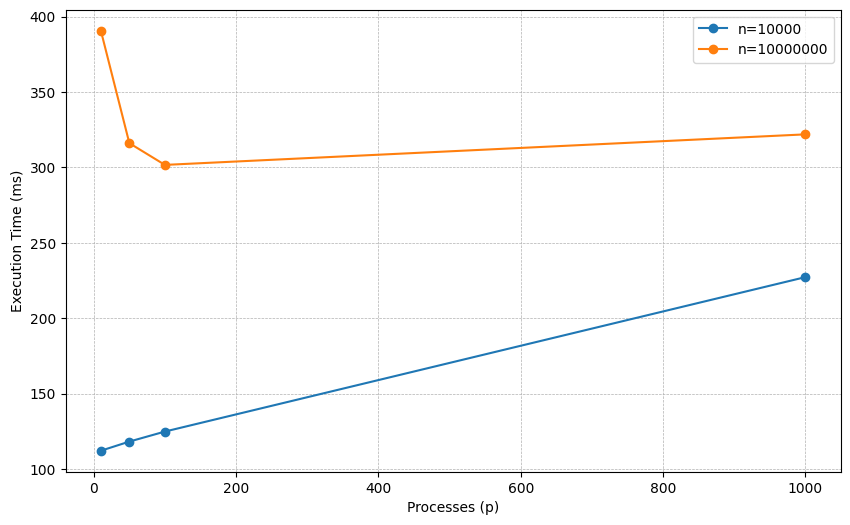

In [27]:
# Plotar os resultados
plt.figure(figsize=(10, 6))

for n, data in execution_times.items():
    data.sort()  # Ordenar por n
    x_vals, y_vals = zip(*data)
    plt.plot(x_vals, y_vals, marker='o', label=f'n={n}')

plt.xlabel('Processes (p)')
plt.ylabel('Execution Time (ms)')
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


## Multithreading
1. Appliquer l’algorithme suivant en distribuant les calculs parmis les *workers* d’un `ThreadPoolExecutor`.
2. Mesurer les temps de restitution en variant le nombre de tir et le nombre de thread.
3. Comparer avec les versions précédentes.

In [18]:
def pi_mc_mt(n,t):
    r = n//t
    tic = time.time()
    chunk = [xxyy[:,i:i + r] for i in range(0, n, r)]
    t_exe = ThreadPoolExecutor(4)
    result = [res for res in t_exe.map(pick_np,chunk)]
    count = sum(result)
    pi = 4 * count / n
    toc = time.time()
    execution_time = (toc - tic) * 1000 
    print(f'For {n} picks and {t} threads, pi ≈ {pi:.4f} in {execution_time:.2f} ms')
    return execution_time


values_n = [10_000, 10_000, 10_000, 10_000, 10_000_000, 10_000_000, 10_000_000, 10_000_000]
values_t = [2, 4, 6, 8, 2, 4, 6, 8]
execution_times = {n: [] for n in set(values_n)}

# Executar a função para cada par (n, p)
for n, t in zip(values_n, values_t):
    exec_time = pi_mc_mt(n, t)
    execution_times[n].append((t, exec_time))



# for i in range(len(values_n)):
#     pi_mc_mt(values_n[i], threads_values[i])

For 10000 picks and 2 threads, pi ≈ 3.1428 in 0.96 ms
For 10000 picks and 4 threads, pi ≈ 3.1428 in 0.78 ms
For 10000 picks and 6 threads, pi ≈ 3.6680 in 0.83 ms
For 10000 picks and 8 threads, pi ≈ 3.1428 in 0.84 ms
For 10000000 picks and 2 threads, pi ≈ 3.1413 in 75.39 ms
For 10000000 picks and 4 threads, pi ≈ 3.1413 in 74.72 ms
For 10000000 picks and 6 threads, pi ≈ 3.1413 in 69.14 ms
For 10000000 picks and 8 threads, pi ≈ 3.1413 in 63.67 ms


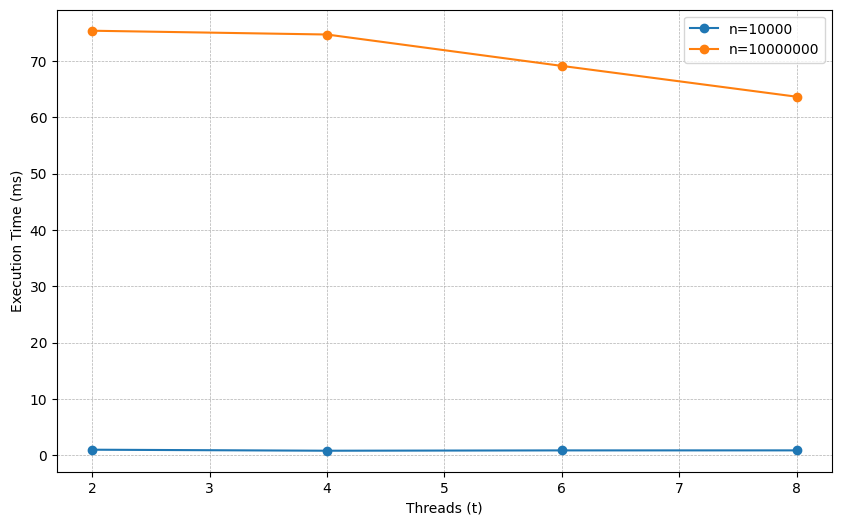

In [19]:
# Plotar os resultados
plt.figure(figsize=(10, 6))

for n, data in execution_times.items():
    data.sort()  # Ordenar por n
    x_vals, y_vals = zip(*data)
    plt.plot(x_vals, y_vals, marker='o', label=f'n={n}')

plt.xlabel('Threads (t)')
plt.ylabel('Execution Time (ms)')
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

## Optimisation
1. Modifier les méthodes suivantes afin de ne générer temporairement que les sous-tableaux.
2. Effectuer de nouvelles mesures de performance.

In [ ]:
def pick_np_opt(n):
    xxyy =np.random.uniform(-1, 1, size=(2, n))
    norm = np.linalg.norm(xxyy, axis=0)
    count = np.sum(norm <= 1)
    return count

In [ ]:
def pi_mc_mp(n,p):
    r = n//p
    tic = time.time()
    chunk = [xxyy[:,i:i + r] for i in range(0, n, r)]
    p_exe = ProcessPoolExecutor(4)
    result = [res for res in p_exe.map(pick_np,chunk)]
    count = sum(result)
    pi = 4 * count / n
    toc = time.time()
    execution_time = (toc - tic) * 1000 
    print(f'For {n} picks and {p} processes, pi ≈ {pi:.4f} in {execution_time:.2f} ms')
    return execution_time

values_n = [10_000, 10_000, 10_000, 10_000, 10_000_000, 10_000_000, 10_000_000, 10_000_000]
values_p = [10, 50, 100, 1000, 10, 50, 100, 1000]
execution_times = {n: [] for n in set(values_n)}

# Executar a função para cada par (n, p)
for n, p in zip(values_n, values_p):
    exec_time = pi_mc_mp(n, p)
    execution_times[n].append((p, exec_time))